In [152]:
# predict price of nat gas given a date as input

# Requirements: predicts for
# up to 1 year into the future (2025-09-30)
# any day in the past

# after functions generate_vars_for_models(), run_linear_regression(), and run_holt_winters()
# are defined, we plug in dates to see past and future plots with price predictions
%reset -f

In [153]:
# imports
import os
import sys
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [154]:
# load nat gas data into dataframe
def load_data(filename: str):
    if not os.path.exists(filename):
        print(f"File {filename} does not exist")
        sys.exit(1)

    df = None
    with open(filename, "r") as fin:
        try:
            df = pd.read_csv(fin, parse_dates=["Dates"],
                             date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%y"))
        except Exception as e:
            print(f"Failed to read {filename}: {e}")
            sys.exit(1)

    if df is None:
        print(f"Failed to read {filename}")
        sys.exit(1)

    # Drop rows with missing values
    df.dropna(inplace=True)

    return df


ROOT="/content" # ROOT="/content/TaskOne"
data = os.path.join(ROOT, 'data/Nat_Gas.csv')
df = load_data(data)

<ipython-input-154-c7609fd35c5d>:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fin, parse_dates=["Dates"],


In [155]:
# print out statistics on the data in the df
print("df.shape: ", df.shape)

print("df.dtypes:\n", df.dtypes)

print("\ndf.info: ", df.info())  # .info() doesn't return a value, it prints directly

print("\ndf.describe:\n", df.describe())

print("\ndf['Prices'].median: $", df['Prices'].median())

print("\ndf['Prices'].mode: $", df['Prices'].mode())

print("\ndf['Prices'].skew: ", df['Prices'].skew())

print("\ndf['Prices'].kurt: ", df['Prices'].kurt())

print("\ndf['Prices'].var: ", df['Prices'].var())

df.shape:  (48, 2)
df.dtypes:
 Dates     datetime64[ns]
Prices           float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes

df.info:  None

df.describe:
                      Dates     Prices
count                   48  48.000000
mean   2022-10-15 08:00:00  11.207083
min    2020-10-31 00:00:00   9.840000
25%    2021-10-23 06:00:00  10.650000
50%    2022-10-15 12:00:00  11.300000
75%    2023-10-07 18:00:00  11.625000
max    2024-09-30 00:00:00  12.800000
std                    NaN   0.757897

df['Prices'].median: $ 11.3

df['Prices'].mode: $ 0    11.5
Name: Prices, dtype: float64

df['Prices'].skew:  0.12636509165164392

df['Prices'].kurt:  -0.6655230197811757

df['Prices'].var:

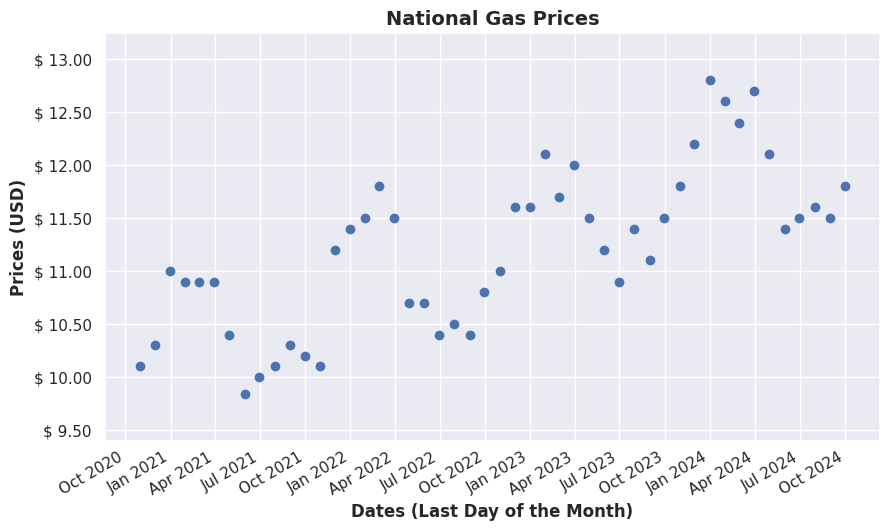

In [156]:
# plot the data

# print(plt.style.available)
plt.style.use('seaborn-v0_8-pastel')
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("National Gas Prices", fontsize=14, fontweight='bold')
plt.xlabel("Dates (Last Day of the Month)", fontsize=12, fontweight='bold')
plt.ylabel("Prices (USD)", fontsize=12, fontweight='bold')

plt.scatter(df["Dates"], df["Prices"])

# show every 3rd month on x-axis to not be too cluttered
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Full date format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # tick interval
# money with two places past the decimal
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'$ {x:.2f}'))

plt.gcf().autofmt_xdate()  # Rotate date labels to fit
plt.grid(True)
plt.gca().tick_params(axis='x', pad=0)  # Adjust padding to bring labels closer

min_price = df["Prices"].min()
max_price = df["Prices"].max()

ylim_buffer = (max_price - min_price) * 0.15
plt.ylim(min_price - ylim_buffer, max_price + ylim_buffer)

# save plot
visuals_dir = os.path.join(os.getcwd(), "visuals")
os.makedirs(visuals_dir, exist_ok=True)
# preserve old plots
if os.path.exists(os.path.join(visuals_dir, 'scatter_nat_gas.png')):
    old_plot_name = os.path.join(visuals_dir, 'scatter_nat_gas.{}.png'.format(
        time.strftime("%Y-%m-%d-%H:%M:%S")))
    os.rename(os.path.join(visuals_dir, 'scatter_nat_gas.png'), old_plot_name)

plot_name = os.path.join(visuals_dir, 'scatter_nat_gas.png')
plt.savefig(plot_name)

plt.show()

In [158]:
# Linear Regression to get a benchmark of price prediction
# takes into account YoY price changes but not seasonality

def run_linear_regression(PREDICT_DATE: str):
    # Train the Linear Regression Model
    model_lin_reg = LinearRegression()
    model_lin_reg.fit(X_train, y_train)

    predicted_future_prices = model_lin_reg.predict(future_days_since)

    # if the predict date is before our draining data begins (in the past)
    if num_months_back > 0:
        past_dates = pd.date_range(start=training_day_first - pd.DateOffset(months=num_months_back), periods=num_months_back, freq="M")
        past_days_since = (past_dates - training_day_first).days  # Get days as a NumPy array
        past_days_since = np.array(past_days_since).reshape(-1, 1)  # Reshape to 2D array
        past_prices = model_lin_reg.predict(past_days_since)
    # predict date is within training data range or in the future
    else:
        past_prices = []

    # Predict price for the specified date
    date_predicted_days_since = (pd.to_datetime(PREDICT_DATE) - training_day_first).days
    predicted_price = model_lin_reg.predict([[date_predicted_days_since]])[0]

    # Calculate metrics for the fitted model
    r2 = r2_score(y_train, model_lin_reg.predict(X_train))
    rmse = np.sqrt(mean_squared_error(y_train, model_lin_reg.predict(X_train)))
    mae = mean_absolute_error(y_train, model_lin_reg.predict(X_train))


    # Function to plot the data with the fitline and the predicted price
    def plot_linear_regression_with_fitline(df: pd.DataFrame, model, future_dates, future_prices, past_dates, past_prices, predicted_price, date_predict):
        plt.figure(figsize=(12, 6))
        plt.title("National Gas Prices with Model Fit and Prediction", fontsize=14, fontweight='bold')
        plt.xlabel("Dates (Last Day of the Month)", fontsize=12, fontweight='bold')
        plt.ylabel("Prices (USD)", fontsize=12, fontweight='bold')

        plt.scatter(df["Dates"], df["Prices"], label="Observed Prices", color="blue")

        # Generate predictions for the fitline using the model on historical data
        X_full = (df['Dates'] - df['Dates'].min()).dt.days.values.reshape(-1, 1)
        predicted_full = model.predict(X_full)

        # Plot the fitline for historical data
        plt.plot(df['Dates'], predicted_full, label="Model Fit (Trendline)", color="orange", linewidth=2)

        # Plot the predicted prices for future dates
        plt.plot(future_dates, future_prices, label="Predicted Future Prices", color="green", linestyle='--', linewidth=2)

        # Plot the predicted past prices if they exist
        if len(past_prices) > 0:
            plt.plot(past_dates, past_prices, label="Predicted Past Prices", color="green", linestyle='-.', linewidth=2)

        # Highlight the predicted price for the given date
        plt.scatter(pd.to_datetime(date_predict), predicted_price, color='red', s=100,
                    label=f"Predicted price ${predicted_price:.2f} on {date_predict}", zorder=5)

        # Formatting for dates on the x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        # Calculate dynamic interval for x-axis labels (prevent overcrowding)
        x_ax_month_interval = math.ceil((past_dates.shape[0] + X_train.shape[0] + future_dates.shape[0]) / 12)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=x_ax_month_interval))  # Set major ticks based on calculated interval
        plt.gcf().autofmt_xdate()  # diagonal date labels

        # Format y-axis to display prices in dollars
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'$ {x:.2f}'))

        # Add legend for R2, RMSE, and MAE in the bottom right
        # Show how good the model is at fitting the data
        plt.text(0.95, 0.05, f'R2 score: {r2:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}',
                verticalalignment='bottom', horizontalalignment='right',
                transform=plt.gca().transAxes,
                color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

        plt.grid(True); plt.legend(loc="upper left"); plt.show()


    print(f"On {PREDICT_DATE}, the expected gas price is ${predicted_price:.2f}")

    plot_linear_regression_with_fitline(df, model_lin_reg, future_dates, predicted_future_prices, past_dates, past_prices, predicted_price, PREDICT_DATE)

In [159]:
# Holt-Winters model for optimal price prediction
# this excels with time-series data and seasonal trends

def run_holt_winters(PREDICT_DATE: str):
    # Calculate the number of months to predict back
    sequence_length = abs(int(np.ceil(num_months_back / 12)) * 12)

    # Fit Holt-Winters model with trend and seasonality for future predictions
    model_hw = ExponentialSmoothing(df['Prices'], trend='add', seasonal='add', seasonal_periods=12)
    fit_hw = model_hw.fit()

    # Predict forward for visualization purposes
    forecast_steps = 12
    future_dates = pd.date_range(start=df['Dates'].max() + pd.DateOffset(months=1), periods=forecast_steps, freq="M")
    future_forecast = fit_hw.forecast(steps=forecast_steps)
    forecast_df = pd.DataFrame({"Dates": future_dates, "Forecast": future_forecast.values})

    # Invert the DataFrame for past prediction
    df_inverted = df.iloc[::-1].reset_index(drop=True)

    # Fit the Holt-Winters model on the inverted series for past prediction
    model_hw_inverted = ExponentialSmoothing(df_inverted['Prices'], trend='add', seasonal='add', seasonal_periods=12)
    fit_hw_inverted = model_hw_inverted.fit()

    # Predict backward (on the inverted data)
    past_forecast = fit_hw_inverted.forecast(steps=sequence_length)

    # Create past dates for the inverted forecast
    past_dates = pd.date_range(start=df['Dates'].min() - pd.DateOffset(months=sequence_length),
                                periods=sequence_length, freq="M")
    past_forecast_df = pd.DataFrame({"Dates": past_dates, "Forecast": past_forecast.values[::-1]})  # Flip back the forecast

    # Calculate R2, RMSE, and MAE
    r2 = r2_score(df['Prices'], fit_hw.fittedvalues)
    rmse = np.sqrt(mean_squared_error(df['Prices'], fit_hw.fittedvalues))
    mae = mean_absolute_error(df['Prices'], fit_hw.fittedvalues)

    # Function to plot observed data, Holt-Winters trendline, and forecast
    def plot_holt_winters_with_forecast(df, forecast_df, past_forecast_df, predicted_price, date_predict):
        # Initialize the plot
        plt.figure(figsize=(10, 6))
        plt.title("National Gas Prices with Holt-Winters Fit and Prediction", fontsize=14, fontweight='bold')
        plt.xlabel("Dates (Last Day of the Month)", fontsize=12, fontweight='bold')
        plt.ylabel("Prices (USD)", fontsize=12, fontweight='bold')

        plt.scatter(df["Dates"], df["Prices"], label="Observed Prices", color="blue")

        # Plot the Holt-Winters trendline for the historical data (orange)
        plt.plot(df['Dates'], fit_hw.fittedvalues,
                label="Holt-Winters Fit (Training)", color="orange", linewidth=2)

        # Plot the forecasted future trendline (green)
        plt.plot(forecast_df["Dates"], forecast_df["Forecast"],
                label="Forecasted Prices (Future)", color="green", linestyle='--', linewidth=2)

        # Plot the forecasted past trendline (dashed green)
        plt.plot(past_forecast_df["Dates"], past_forecast_df["Forecast"],
                label="Forecasted Prices (Past)", color="green", linestyle='-.', linewidth=2)

        # Highlight the predicted price for the given date
        plt.scatter(pd.to_datetime(date_predict), predicted_price, color='red', s=100,
                    label=f"Predicted price ${predicted_price:.2f} on {date_predict}", zorder=5)

        # Formatting for dates on the x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        x_ax_month_interval = math.ceil((past_dates.shape[0] + X_train.shape[0] + future_dates.shape[0]) / 12)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=x_ax_month_interval))
        plt.gcf().autofmt_xdate()

        # Format y-axis to display prices in dollars
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'$ {x:.2f}'))

        # Add legend for R2, RMSE, and MAE in the bottom right
        plt.text(0.95, 0.05, f'R2 score: {r2:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}',
                    verticalalignment='bottom', horizontalalignment='right',
                    transform=plt.gca().transAxes,
                    color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

        plt.grid(True); plt.legend(loc="upper left"); plt.show()

    # Function to find the closest date in the forecast
    def find_closest_date(forecast_df, target_date):
        closest_date_idx = np.abs(forecast_df['Dates'] - pd.to_datetime(target_date)).idxmin()
        return forecast_df.iloc[closest_date_idx]

    if pd.to_datetime(PREDICT_DATE) > df['Dates'].max():
        closest_forecast = find_closest_date(forecast_df, PREDICT_DATE)
    else:
        closest_forecast = find_closest_date(past_forecast_df, PREDICT_DATE)

    predicted_price = closest_forecast['Forecast']
    print(f"On {PREDICT_DATE}, the expected gas price is ${predicted_price:.2f}")

    plot_holt_winters_with_forecast(df, forecast_df, past_forecast_df, predicted_price, PREDICT_DATE)

In [160]:
# PREDICT_DATE = "1975-12-26" # valid, negative
# PREDICT_DATE = "1995-12-26" # valid, typically negative
# PREDICT_DATE = "2000-06-26" # valid
# PREDICT_DATE = "2010-03-11" # valid
# PREDICT_DATE = "2015-08-15" # valid
# PREDICT_DATE = "2019-12-26" # valid
# PREDICT_DATE = "2021-12-26" # invalid - within training data timeframe
# PREDICT_DATE = "2024-12-26" # valid
# PREDICT_DATE = "2025-08-15" # valid
# PREDICT_DATE = "2028-08-15" # invalid, beyond 1 year future limit
# PREDICT_DATE = "2030-08-15" # invalid

PAST_PREDICT_DATE = "2005-02-12"
BAD_PREDICT_DATE =  "2022-09-20"
FUTURE_PREDICT_DATE = "2025-08-28"

<ipython-input-154-c7609fd35c5d>:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fin, parse_dates=["Dates"],


On 2005-02-12, the expected gas price is $2.93


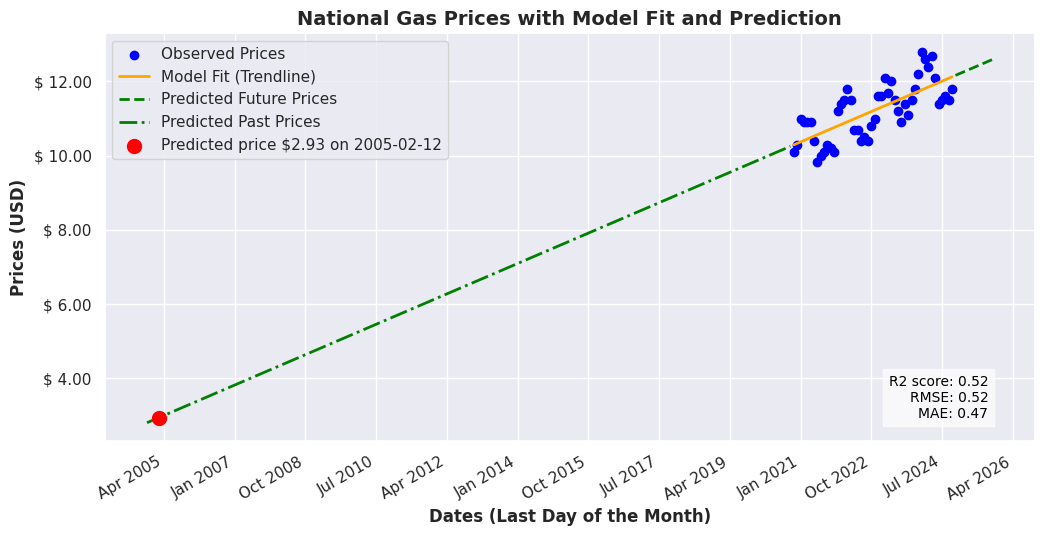

On 2005-02-12, the expected gas price is $2.30


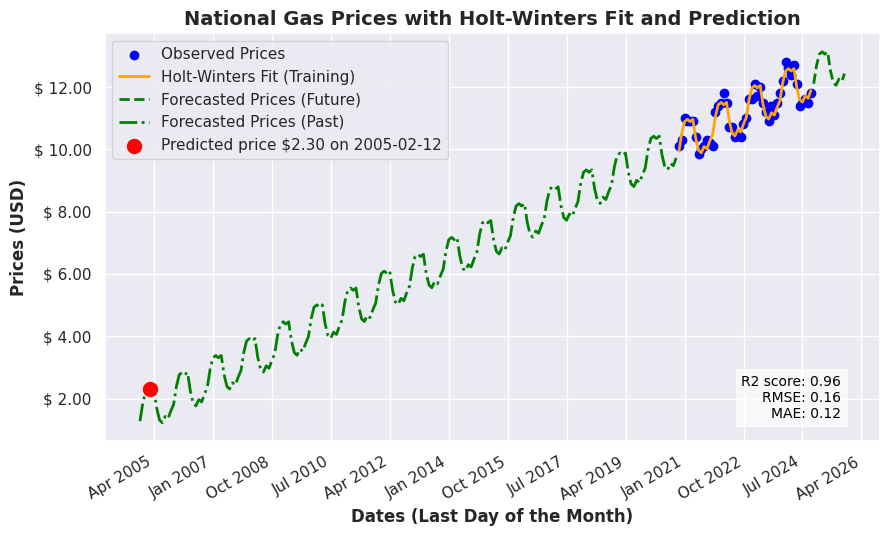

In [161]:
# generate_vars_for_models
predict_date = pd.to_datetime(PAST_PREDICT_DATE)

df = load_data(data)
df['Dates'] = pd.to_datetime(df['Dates'], format="%Y-%m-%d")
df.sort_values('Dates', inplace=True)
df.reset_index(drop=True, inplace=True)

# consider using test data or just training on all
X_train = (df['Dates'] - df['Dates'].min()).dt.days.values.reshape(-1, 1)
y_train = df['Prices'].values

training_day_first = df['Dates'].min()
training_day_last = df["Dates"].max()
# enforce that forecast date is before training data or after it
if not (predict_date < training_day_first or predict_date > training_day_last):
    print('Error: Must enter a prediction date before {}'.format(training_day_first.strftime("%Y-%m-%d")))
    print('\tor after {}\n'.format(training_day_last.strftime("%Y-%m-%d")))
    sys.exit(1)

# extrapolate 1 year in future
future_month_first = (training_day_last + pd.DateOffset(months=1))
future_dates = pd.date_range(start=future_month_first, periods=12, freq="M")
# make days into 2D numpy array
future_days_since = (future_dates - training_day_first).days
future_days_since = np.array(future_days_since).reshape(-1, 1)

# show one year of trendline in the non-forecasted time period
num_months_back = 0

# Calculate the number of months to predict back
if predict_date < training_day_first:
    num_months_back = np.ceil((training_day_first - pd.to_datetime(PAST_PREDICT_DATE)).days / 30)
    future_steps = 12
elif predict_date > training_day_last:
    # if future date > 1 year beyond training data exit with error per reqs
    if (predict_date - training_day_last).days > 366:
        print('Error: Must enter a prediction date within 1 year of training data')
        sys.exit(1)

    past_steps, num_months_back = 12, 12

# create both models and predict then graph
run_linear_regression(PAST_PREDICT_DATE)
run_holt_winters(PAST_PREDICT_DATE)

<ipython-input-154-c7609fd35c5d>:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fin, parse_dates=["Dates"],


On 2025-08-28, the expected gas price is $12.55


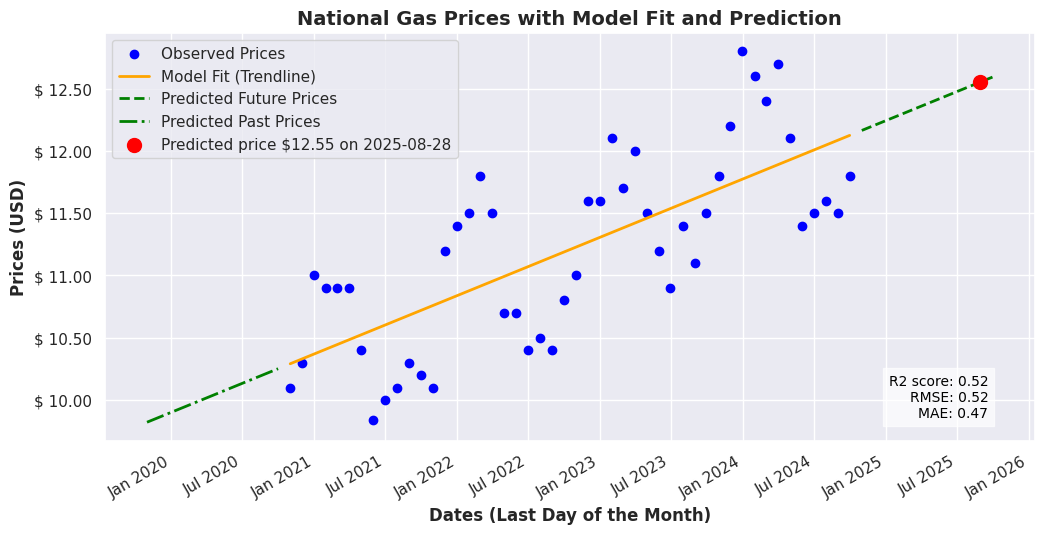

On 2025-08-28, the expected gas price is $12.18


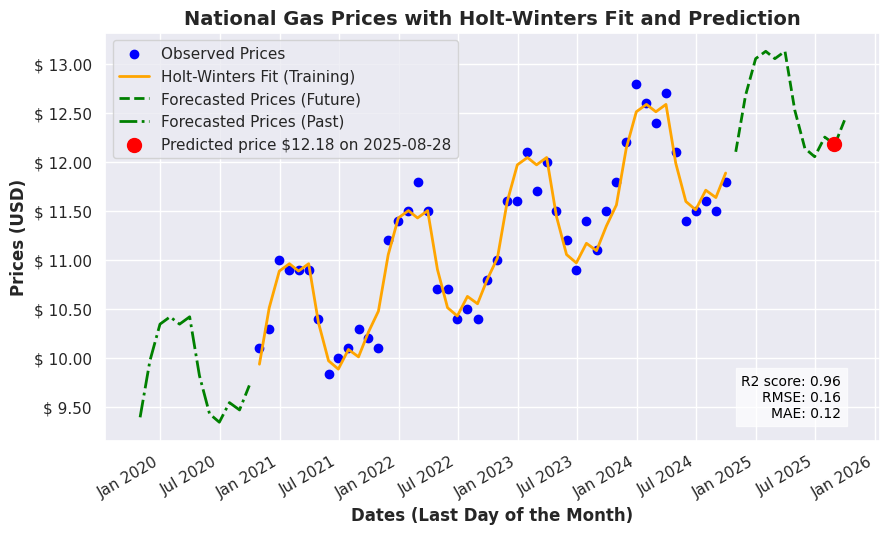

In [162]:
# generate_vars_for_models
predict_date = pd.to_datetime(FUTURE_PREDICT_DATE)

df = load_data(data)
df['Dates'] = pd.to_datetime(df['Dates'], format="%Y-%m-%d")
df.sort_values('Dates', inplace=True)
df.reset_index(drop=True, inplace=True)

# consider using test data or just training on all
X_train = (df['Dates'] - df['Dates'].min()).dt.days.values.reshape(-1, 1)
y_train = df['Prices'].values

training_day_first = df['Dates'].min()
training_day_last = df["Dates"].max()
# enforce that forecast date is before training data or after it
if not (predict_date < training_day_first or predict_date > training_day_last):
    print('Error: Must enter a prediction date before {}'.format(training_day_first.strftime("%Y-%m-%d")))
    print('\tor after {}\n'.format(training_day_last.strftime("%Y-%m-%d")))
    sys.exit(1)

# extrapolate 1 year in future
future_month_first = (training_day_last + pd.DateOffset(months=1))
future_dates = pd.date_range(start=future_month_first, periods=12, freq="M")
# make days into 2D numpy array
future_days_since = (future_dates - training_day_first).days
future_days_since = np.array(future_days_since).reshape(-1, 1)

# show one year of trendline in the non-forecasted time period
num_months_back = 0

# Calculate the number of months to predict back
if predict_date < training_day_first:
    num_months_back = np.ceil((training_day_first - pd.to_datetime(FUTURE_PREDICT_DATE)).days / 30)
    future_steps = 12
elif predict_date > training_day_last:
    # if future date > 1 year beyond training data exit with error per reqs
    if (predict_date - training_day_last).days > 366:
        print('Error: Must enter a prediction date within 1 year of training data')
        sys.exit(1)

    past_steps, num_months_back = 12, 12

# create both models and predict then graph
run_linear_regression(FUTURE_PREDICT_DATE)
run_holt_winters(FUTURE_PREDICT_DATE)

In [163]:
# generate_vars_for_models
predict_date = pd.to_datetime(BAD_PREDICT_DATE)

df = load_data(data)
df['Dates'] = pd.to_datetime(df['Dates'], format="%Y-%m-%d")
df.sort_values('Dates', inplace=True)
df.reset_index(drop=True, inplace=True)

# consider using test data or just training on all
X_train = (df['Dates'] - df['Dates'].min()).dt.days.values.reshape(-1, 1)
y_train = df['Prices'].values

training_day_first = df['Dates'].min()
training_day_last = df["Dates"].max()
# enforce that forecast date is before training data or after it
if not (predict_date < training_day_first or predict_date > training_day_last):
    print('Error: Must enter a prediction date before {}'.format(training_day_first.strftime("%Y-%m-%d")))
    print('\tor after {}\n'.format(training_day_last.strftime("%Y-%m-%d")))
    sys.exit(1)

# extrapolate 1 year in future
future_month_first = (training_day_last + pd.DateOffset(months=1))
future_dates = pd.date_range(start=future_month_first, periods=12, freq="M")
# make days into 2D numpy array
future_days_since = (future_dates - training_day_first).days
future_days_since = np.array(future_days_since).reshape(-1, 1)

# show one year of trendline in the non-forecasted time period
num_months_back = 0

# Calculate the number of months to predict back
if predict_date < training_day_first:
    num_months_back = np.ceil((training_day_first - pd.to_datetime(BAD_PREDICT_DATE)).days / 30)
    future_steps = 12
elif predict_date > training_day_last:
    # if future date > 1 year beyond training data exit with error per reqs
    if (predict_date - training_day_last).days > 366:
        print('Error: Must enter a prediction date within 1 year of training data')
        sys.exit(1)

    past_steps = 12
    num_months_back = 12


run_linear_regression(BAD_PREDICT_DATE)
run_holt_winters(BAD_PREDICT_DATE)

Error: Must enter a prediction date before 2020-10-31
	or after 2024-09-30



<ipython-input-154-c7609fd35c5d>:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fin, parse_dates=["Dates"],


SystemExit: 1

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# view session requirements
!pip install session_info
import session_info
session_info.show(html=False)
# view packages